In [39]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization,Activation, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import Adam
from PIL import Image 
import numpy as np
import re
import os 
import glob 
import random
import logging

# Set TensorFlow logging level to suppress warnings
tf.get_logger().setLevel(logging.ERROR)

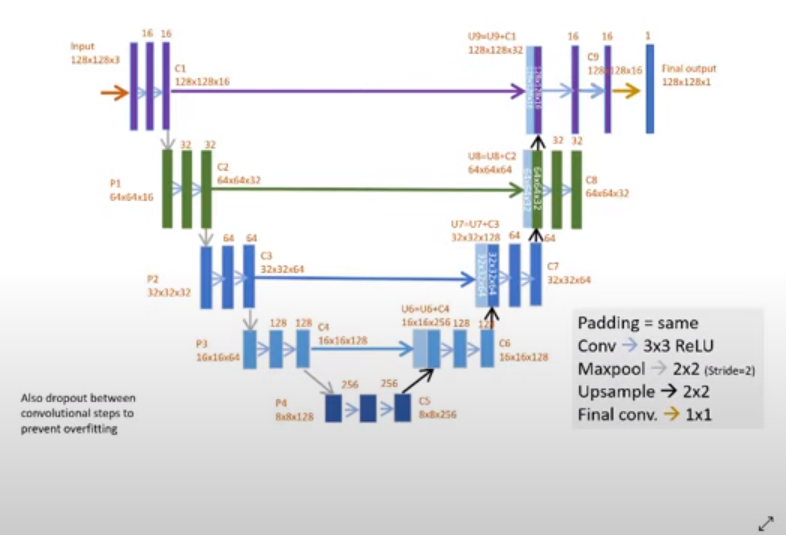

In [2]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape, n_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    c1, p1 = encoder_block(inputs, 16)
    c2, p2 = encoder_block(p1, 32)
    c3, p3 = encoder_block(p2, 64)
    c4, p4 = encoder_block(p3, 128)

    c5 = conv_block(p4, 256) #Bridge
    c6 = decoder_block(c5, c4, 128)
    c7 = decoder_block(c6, c3, 64)
    c8 = decoder_block(c7, c2, 32)
    c9 = decoder_block(c8, c1, 16)

    if n_classes == 1:  #Binary
        activation = 'sigmoid'
    else:
        activation = 'softmax'
    
    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(c9)
    model = Model(inputs, outputs, name="U-Net")
    return model

In [27]:
# def conv_block(input, num_filters):
#     x = Conv2D(num_filters, 3, padding="same", use_bias=False)(input)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     x = Conv2D(num_filters, 3, padding="same", use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     return x


# def encoder_block(input, num_filters):
#     x = conv_block(input, num_filters)
#     p = MaxPool2D((2, 2))(x)
#     return x, p


# def decoder_block(input, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters)
#     return x


# def build_unet(input_shape, n_classes):
#     inputs = tf.keras.layers.Input(shape=input_shape)
#     s1, p1 = encoder_block(inputs, 32)
#     s2, p2 = encoder_block(p1, 64)
#     s3, p3 = encoder_block(p2, 128)

#     b1 = conv_block(p3, 512) #Bridge
#     d2 = decoder_block(b1, s3, 128)
#     d3 = decoder_block(d2, s2, 64)
#     d4 = decoder_block(d3, s1, 32)

#     if n_classes == 1:  #Binary
#         activation = 'sigmoid'
#     else:
#         activation = 'softmax'

#     outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)
#     model = Model(inputs, outputs, name="U-Net")
#     return model

In [3]:
model = build_unet((128,128,3), 1)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [34]:
# import re
# import os 
# import glob 

# class DataReader(object):
#     def __init__(self, img_dir, label_dir, img_size):
#         self.img_dir = img_dir
#         self.label_dir = label_dir
#         self.imgs_path = glob.glob(f"{self.img_dir}/*.jpg")
#         self.num_imgs = len(self.imgs_path)
#         self.width, self.height = img_size
    
#     def __len__(self):
#         return self.num_imgs
    
    
#     def resize_crop_pad(self, img, is_label=False):
#         """
#         img -> PIL.Image
#         return -> PIL.Image
#         """
#         target_width, target_height = self.width, self.height
#         original_width, original_height = img.size
#         original_aspect_ratio = original_width / original_height
#         target_aspect_ratio = target_width / target_height
#         if original_aspect_ratio > target_aspect_ratio:
#             scale_factor = target_width / original_width
#         else:
#             scale_factor = target_height / original_height

#         resized_image = img.resize((int(original_width * scale_factor), int(original_height * scale_factor)), Image.BILINEAR)
#         if is_label:
#             padded_image = Image.new("L", (target_width, target_height))
#         else:
#             padded_image = Image.new("RGB", (target_width, target_height), color=(0, 0, 0))
#         paste_x = (target_width - resized_image.width) // 2
#         paste_y = (target_height - resized_image.height) // 2
#         padded_image.paste(resized_image, (paste_x, paste_y))

#         return padded_image
    
#     def binarize_image(self, img):
#         """
#         image -> PIL.Image
#         return -> PIL.Image
#         """
#         img = img.convert("L")
#         img_array = np.array(img)
#         binary_img_array = np.where(img_array > 0, 1, 0)
#         binary_img = Image.fromarray(binary_img_array.astype(np.uint8), mode="L")
#         return binary_img
    
    
#     def find_label(self, img_path):
#         label_path = re.sub(self.img_dir, self.label_dir, img_path)
#         label_path = re.sub(".jpg", ".png", label_path)
#         return label_path if os.path.exists(label_path) else None
    
    
#     def __getitem__(self, index):
#         img_path = self.imgs_path[index]
#         label_path = self.find_label(img_path)
#         img = Image.open(img_path)
#         img = self.resize_crop_pad(img)
#         if label_path:
#             label = Image.open(label_path)
#         else:
#             image_data = np.zeros((128, 128, 3), dtype=np.uint8)
#             label = Image.fromarray(image_data)
#         label = self.resize_crop_pad(label, is_label=True)
#         label = self.binarize_image(label)
#         img_np = np.array(img) / 255.
#         label_np = np.expand_dims(np.array(label), -1)
#         return img_np, label_np        
    
#     def iter(self):
#         for i in range(self.num_imgs):
#             yield self[i]

In [4]:
class DataReader(object):
    def __init__(self, img_dir, mask_dir, is_training=True, img_size=(128, 128)):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.imgs_path = glob.glob(f"{self.img_dir}/*.jpg")
        self.num_imgs = len(self.imgs_path)
        self.img_h, self.img_w = img_size
        self.is_training = is_training
    
    
    def find_mask(self, img_path):
        mask_path = re.sub(self.img_dir, self.mask_dir, img_path)
        mask_path = re.sub(".jpg", ".png", mask_path)
        return mask_path if os.path.exists(mask_path) else None
    
    
    def load_normalized_resize_img(self, img_path, is_mask=False, resize_method=tf.image.ResizeMethod.BILINEAR):
        img = tf.io.read_file(img_path)
        channels = 1 if is_mask else 3
        # tf.image.decode_image if passing dtype=tf.float32, the value is range from [0,1] no need to normalized again 
        img = tf.image.decode_image(img, channels=channels, dtype=tf.float32)
        img = tf.image.resize_with_pad(img, self.img_h, self.img_w, method=resize_method)
        return img
        
    
    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        mask_path = self.find_mask(img_path)
        
        img = self.load_normalized_resize_img(img_path)
        if mask_path:
            mask = self.load_normalized_resize_img(mask_path, is_mask=True)
        else:
            mask = tf.zeros((self.img_h, self.img_w, 1), dtype=tf.float32)
        mask = tf.where(mask > 0, 1., 0)
        
        if self.is_training:
            img, mask = self.geo_transform(img, mask)
            img = self.color_transform(img)
            img = tf.clip_by_value(img, 0, 1)
        
        return img, mask 
    
    
    def iter(self):
        for i in range(self.num_imgs):
            yield self[i]
            
    
    def geo_transform(self, img, mask):
        random_number = random.random()
        if random_number < 0.2:
            img = tf.image.flip_left_right(img)
            mask = tf.image.flip_left_right(mask)
        elif random_number < 0.4:
            img = tf.image.flip_up_down(img)
            mask = tf.image.flip_up_down(mask)
        elif random_number < 0.6:
            img = tf.image.rot90(img, 1)
            mask = tf.image.rot90(mask, 1)
        elif random_number < 0.8:
            img = tf.image.rot90(img, 3)
            mask = tf.image.rot90(mask, 3)
        return img, mask 
    
    
    def color_transform(self, img):
        random_number = random.random()
        if random_number < 0.2:
            img = tf.image.adjust_gamma(img, 0.6)
        elif random_number < 0.6:
            img = tf.image.random_brightness(img, max_delta=0.1)
        return img

In [5]:
batch_size = 256
img_dir = "/app/seg/data/seg_training/images"
label_dir = "/app/seg/data/seg_training/labels"
data_reader = DataReader(img_dir, label_dir, is_training=True, img_size=(128, 128))
dataset = tf.data.Dataset.from_generator(data_reader.iter,
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes=([128, 128, 3], [128, 128, 1]))
dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

In [43]:
from tensorflow.keras import backend as K

def jaccard_coefficient(y_true, y_pred, smooth=1.):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection
    return (intersection + smooth) / (union + smooth)


def jaccard_loss(y_true, y_pred):
    return 1 - jaccard_coefficient

In [ ]:
# model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss, metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=dice_coefficient)
history = model.fit(dataset,
                    epochs=50)

Epoch 1/50
      1/Unknown - 0s 1ms/step - loss: 0.7634 - dice_coefficient: 0.3029WARNING:tensorflow:The operation `tf.image.convert_image_dtype` will be skipped since the input and output dtypes are identical.
      2/Unknown - 5s 3s/step - loss: 0.7117 - dice_coefficient: 0.3248 WARNING:tensorflow:The operation `tf.image.convert_image_dtype` will be skipped since the input and output dtypes are identical.
      3/Unknown - 9s 3s/step - loss: 0.6771 - dice_coefficient: 0.3376WARNING:tensorflow:The operation `tf.image.convert_image_dtype` will be skipped since the input and output dtypes are identical.
      4/Unknown - 11s 3s/step - loss: 0.6488 - dice_coefficient: 0.3530WARNING:tensorflow:The operation `tf.image.convert_image_dtype` will be skipped since the input and output dtypes are identical.
      5/Unknown - 14s 3s/step - loss: 0.6268 - dice_coefficient: 0.3686WARNING:tensorflow:The operation `tf.image.convert_image_dtype` will be skipped since the input and output dtypes are i

In [12]:
model.load_weights("/app/seg/Unet_model.h5")
model.compile(optimizer=Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=['accuracy'])

In [39]:
def resize_crop_pad(img, is_label=False):
    """
    img -> PIL.Image
    return -> PIL.Image
    """
    target_width, target_height = 128, 128
    original_width, original_height = img.size
    original_aspect_ratio = original_width / original_height
    target_aspect_ratio = target_width / target_height
    if original_aspect_ratio > target_aspect_ratio:
        scale_factor = target_width / original_width
    else:
        scale_factor = target_height / original_height

    resized_image = img.resize((int(original_width * scale_factor), int(original_height * scale_factor)), Image.BILINEAR)
    if is_label:
        padded_image = Image.new("L", (target_width, target_height))
    else:
        padded_image = Image.new("RGB", (target_width, target_height), color=(0, 0, 0))
    paste_x = (target_width - resized_image.width) // 2
    paste_y = (target_height - resized_image.height) // 2
    padded_image.paste(resized_image, (paste_x, paste_y))

    return padded_image

In [40]:
img_dir = "/app/seg/data/images/test/"
label_dir = "/app/seg/data/labels/test/"
data_reader = DataReader(img_dir, label_dir, img_size=(128, 128))
test_dataset = tf.data.Dataset.from_generator(data_reader.iter,
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes=([128, 128, 3], [128, 128, 1]))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
model.evaluate(test_dataset)

1/1 [==============================] - 0s 9ms/step - loss: 0.1663 - dice_coefficient: 0.8765


[0.16629427671432495, 0.8764746785163879]

(128, 128, 3)


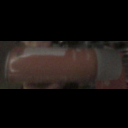

(128, 128, 1)


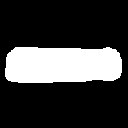

In [11]:
for x,y in test_dataset:
    img = x[0]
    print(img.shape)
    np_array = np.array(img) * 255
    img_p = Image.fromarray(np_array.astype(np.uint8))
    img_p.show()
    label = y[0]
    print(label.shape)
    label_array = np.squeeze(np.array(label)) * 255
    label_p = Image.fromarray(label_array.astype(np.uint8), "L")
    label_p.show()
    break

In [13]:
def resize_crop_pad(img, is_label=False):
    """
    img -> PIL.Image
    return -> PIL.Image
    """
    target_width, target_height = 128, 128
    original_width, original_height = img.size
    original_aspect_ratio = original_width / original_height
    target_aspect_ratio = target_width / target_height
    if original_aspect_ratio > target_aspect_ratio:
        scale_factor = target_width / original_width
    else:
        scale_factor = target_height / original_height

    resized_image = img.resize((int(original_width * scale_factor), int(original_height * scale_factor)), Image.BILINEAR)
    if is_label:
        padded_image = Image.new("L", (target_width, target_height))
    else:
        padded_image = Image.new("RGB", (target_width, target_height), color=(0, 0, 0))
    paste_x = (target_width - resized_image.width) // 2
    paste_y = (target_height - resized_image.height) // 2
    padded_image.paste(resized_image, (paste_x, paste_y))

    return padded_image

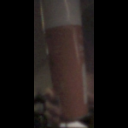

In [35]:
test_img = "/app/seg/data/images/test/9300633320775_1708733394893_2_1708733432295_9626189.jpg"
# test_img = "/app/seg/data/images/test/9300633320775_1708733394893_0_1708733418187_9614769.jpg"
# test_img = "/app/seg/data/images/test/9300633320775_1708733394893_0_1708733430029_9626622.jpg"
# test_img = "/app/seg/data/images/test/9300633320775_1708733394893_1_1708733400006_9603497.jpg"
# test_img = "/app/seg/data/images/test/9300633320775_1708733394893_1_1708733424290_9627776.jpg"
# test_img = "/app/seg/data/images/test/9300633320775_1708733394893_2_1708733405316_9599244.jpg"

test_img = Image.open(test_img)
test_img = resize_crop_pad(test_img)
test_img

In [36]:
test_img_np = np.array(test_img) / 255.
test_img_np = np.expand_dims(test_img_np, 0)
result = model(test_img_np)
output = np.squeeze(result.numpy()) * 255
# output = np.expand_dims(output, -1)
print(output.shape)
output_pil = Image.fromarray(output.astype(np.uint8), "L")

(128, 128)


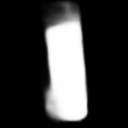

In [37]:
output_pil

In [20]:
def apply_single_channel_mask(image, mask):
    mask_3_channels = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    masked_image = np.where(mask_3_channels, image, 0)
    return masked_image

In [21]:
def binarize_img_np(img_np):
    """
    img -> np.array
    return -> np.array
    """
    binary_img_array = np.where(img_np > 0, 1, 0)
    return binary_img_array.astype(np.uint8)

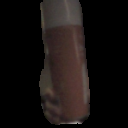

In [38]:
mask = binarize_img_np(np.array(output_pil))
masked_image = apply_single_channel_mask(np.array(test_img), mask)
masked_image_pil = Image.fromarray(masked_image)
masked_image_pil

In [67]:
def crop_masked_region(masked_image, mask):
    # Find bounding box of the mask
    non_zero_indices = np.argwhere(mask)
    min_y, min_x = np.min(non_zero_indices, axis=0)
    max_y, max_x = np.max(non_zero_indices, axis=0)

    # Crop out the region containing the mask
    cropped_masked_image = masked_image[min_y:max_y+1, min_x:max_x+1]

    return cropped_masked_image

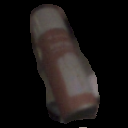

In [68]:
crop = crop_masked_region(masked_image, mask)
crop_pil = Image.fromarray(crop)
crop_pil

In [9]:
model.save("Unet_model_aug.h5")

In [44]:
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
gpu_devices = [x.name for x in local_device_protos if x.device_type == 'GPU']

if gpu_devices:
    print("GPU available:", gpu_devices)
else:
    print("No GPU available, using CPU.")

GPU available: ['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3']
